In [15]:
import os
from pathlib import Path
from decimal import ROUND_HALF_UP, Decimal

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [30]:
# I/O Func
BASE_PATH = Path(f'/kaggle/working')

def adjusting_price(price, key: str):
    """[Adjusting Close Price]
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """

    def generate_adjusted(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, f"CumulativeAdjustmentFactor{key}"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, f"Adjusted{key}"] = (
            df[f"CumulativeAdjustmentFactor{key}"] * df[key]
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df[f"Adjusted{key}"] == 0, f"Adjusted{key}"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, f"Adjusted{key}"] = df.loc[:, f"Adjusted{key}"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted).reset_index(drop=True)

    # price.set_index("Date", inplace=True)
    return price

def adjusting_volume(price, key = "Volume"):
    """[Adjusting Close Price]
    Args:
        price (pd.DataFrame)  : pd.DataFrame include stock_price
    Returns:
        price DataFrame (pd.DataFrame): stock_price with generated AdjustedClose
    """

    def generate_adjusted(df):
        """
        Args:
            df (pd.DataFrame)  : stock_price for a single SecuritiesCode
        Returns:
            df (pd.DataFrame): stock_price with AdjustedClose for a single SecuritiesCode
        """
        # sort data to generate CumulativeAdjustmentFactor
        df = df.sort_values("Date", ascending=False)
        # generate CumulativeAdjustmentFactor
        df.loc[:, f"CumulativeAdjustmentFactor{key}"] = df["AdjustmentFactor"].cumprod()
        # generate AdjustedClose
        df.loc[:, f"Adjusted{key}"] = (
            df[key] / df[f"CumulativeAdjustmentFactor{key}"]  
        ).map(lambda x: float(
            Decimal(str(x)).quantize(Decimal('0.1'), rounding=ROUND_HALF_UP)
        ))
        # reverse order
        df = df.sort_values("Date")
        # to fill AdjustedClose, replace 0 into np.nan
        df.loc[df[f"Adjusted{key}"] == 0, f"Adjusted{key}"] = np.nan
        # forward fill AdjustedClose
        df.loc[:, f"Adjusted{key}"] = df.loc[:, f"Adjusted{key}"].ffill()
        return df

    # generate AdjustedClose
    price = price.sort_values(["SecuritiesCode", "Date"])
    price = price.groupby("SecuritiesCode").apply(generate_adjusted).reset_index(drop=True)

    # price.set_index("Date", inplace=True)
    return price

def read_prices(dir_name: str, securities_code: int = None):
    """[Important: the dateset of 2020/10/1 is lost because of system failer in JPX, see: https://www.jpx.co.jp/corporate/news/news-releases/0060/20201019-01.html]
    
    """
    base_path = Path(f'../input/jpx-tokyo-stock-exchange-prediction/{dir_name}')
    df = pd.read_csv(base_path / 'stock_prices.csv')
    df.loc[: ,"Date"] = pd.to_datetime(df.loc[: ,"Date"], format="%Y-%m-%d")
    df = df[df['Open'].notna()]
    if securities_code:
        df = df[df["SecuritiesCode"] == securities_code]
    return df

def read_stock_list(securities_code: int = None, only_universe: bool = True):
    df = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv')
    df.loc[: ,"EffectiveDate"] = pd.to_datetime(df.loc[: ,"EffectiveDate"], format="%Y%m%d")
    if only_universe:
        df = df[df['Universe0']]
    if securities_code:
        df = df[df["SecuritiesCode"] == securities_code]
    return df

def merge_data(prices, stock_list):
    # stock_prices がベース
    base_df = prices.copy()
    
    # stock_listと結合
    _stock_list = stock_list.copy()
    _stock_list.rename(columns={'Close': 'Close_x'}, inplace=True)
    base_df = base_df.merge(_stock_list, on='SecuritiesCode', how="left")
    
    return base_df

def read_train_data_by_price(securities_code: int = None, with_supplemental: bool = True):
    """[The train base is price dataset, the other data are joined to prices DF by left join]
    
    """
    # origin
    df = merge_data(prices=read_prices(dir_name="train_files", securities_code=securities_code), stock_list=read_stock_list(securities_code=securities_code))
    
    # supplyment
    if with_supplemental:
        supplemental_df = merge_data(prices=read_prices(dir_name="supplemental_files", securities_code=securities_code), stock_list=read_stock_list(securities_code=securities_code))
        df = pd.concat([df, supplemental_df]).reset_index(drop=True)
        
    df = adjusting_price(df, "Close")
    df = adjusting_price(df, "Open")
    df = adjusting_price(df, "High")
    df = adjusting_price(df, "Low")
    df = adjusting_volume(df)
    return df

def collector(prices, options, financials, trades, secondary_prices, stock_list):
    # 読み込んだデータを統合して一つのファイルに纏める
    df = merge_data(prices, stock_list)
    # AdjustedClose項目の生成
    df = adjusting_price(df, "Close")
    df = adjusting_price(df, "Open")
    df = adjusting_price(df, "High")
    df = adjusting_price(df, "Low")
    df = adjusting_volume(df)
    return df

def write_df(df, filename):
    df.to_csv(BASE_PATH / f'{filename}.csv',index = False)
    
import joblib
def write_model(model, name):
    # save model
    joblib.dump(model, f'{BASE_PATH}/{name}.pkl')


# load model
def read_model(name):
    return joblib.load(f'{BASE_PATH}/{name}.pkl')

In [17]:
train_df = read_train_data_by_price()
train_df

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,...,CumulativeAdjustmentFactorClose,AdjustedClose,CumulativeAdjustmentFactorOpen,AdjustedOpen,CumulativeAdjustmentFactorHigh,AdjustedHigh,CumulativeAdjustmentFactorLow,AdjustedLow,CumulativeAdjustmentFactorVolume,AdjustedVolume
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,...,1.0,2742.0,1.0,2734.0,1.0,2755.0,1.0,2730.0,1.0,31400.0
1,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,NaN,...,1.0,2738.0,1.0,2743.0,1.0,2747.0,1.0,2735.0,1.0,17900.0
2,20170106_1301,2017-01-06,1301,2734.0,2744.0,2720.0,2740.0,19900,1.0,NaN,...,1.0,2740.0,1.0,2734.0,1.0,2744.0,1.0,2720.0,1.0,19900.0
3,20170110_1301,2017-01-10,1301,2745.0,2754.0,2735.0,2748.0,24200,1.0,NaN,...,1.0,2748.0,1.0,2745.0,1.0,2754.0,1.0,2735.0,1.0,24200.0
4,20170111_1301,2017-01-11,1301,2748.0,2752.0,2737.0,2745.0,9300,1.0,NaN,...,1.0,2745.0,1.0,2748.0,1.0,2752.0,1.0,2737.0,1.0,9300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2436634,20220221_9997,2022-02-21,9997,725.0,729.0,719.0,727.0,116400,1.0,NaN,...,1.0,727.0,1.0,725.0,1.0,729.0,1.0,719.0,1.0,116400.0
2436635,20220222_9997,2022-02-22,9997,719.0,723.0,711.0,721.0,225500,1.0,NaN,...,1.0,721.0,1.0,719.0,1.0,723.0,1.0,711.0,1.0,225500.0
2436636,20220224_9997,2022-02-24,9997,709.0,725.0,708.0,719.0,195600,1.0,NaN,...,1.0,719.0,1.0,709.0,1.0,725.0,1.0,708.0,1.0,195600.0
2436637,20220225_9997,2022-02-25,9997,725.0,738.0,724.0,733.0,170500,1.0,NaN,...,1.0,733.0,1.0,725.0,1.0,738.0,1.0,724.0,1.0,170500.0


# Featrue

In [18]:
def cal_moving_average(key:str, periods):
    def func(df):
        for period in periods:
            col = f"MovingAverage{key}{period}"
            col_gap = f"{col}GapPercent"
            df[col] = df[key].rolling(period, min_periods=1).mean()
            df[col_gap] = (df[key] / df[col]) * 100.0
        return df
    return func

def cal_changing_ration(key:str, periods):
    def func(df):
        for period in periods:
            col = f"ChangingRatio{key}{period}"
            df[col] = df[key].pct_change(period) * 100
        return df
    return func

def cal_historical_vix(key: str, periods):
    def func(df):
        for period in periods:
            col = f"HistoricalVIX{key}{period}"
            df[col] = np.log(df[key]).diff().rolling(period).std()
        return df
    return func

def add_columns_per_code(df, functions):
    def func(df):
        for f in functions:
            df = f(df)
        return df
    df = df.sort_values(["SecuritiesCode", "Date"])
    df = df.groupby("SecuritiesCode").apply(func)
    df = df.reset_index(drop=True)
    return df

def add_columns_per_day(base_df):
    base_df['diff_rate1'] = (base_df['Close'] - base_df['Open']) / base_df['Close']
    base_df['diff_rate2'] = (base_df['High'] - base_df['Low']) / base_df['Close']    
    return base_df

def generate_features(df):
    base_df = df.copy()
    prev_column_names = base_df.columns
    periods = [5, 25, 75]
    functions = [
        cal_moving_average("AdjustedClose", periods),
        cal_moving_average("AdjustedOpen", periods),
        cal_moving_average("AdjustedHigh", periods),
        cal_moving_average("AdjustedLow", periods),
        cal_moving_average("AdjustedVolume", periods),
        cal_changing_ration("AdjustedClose", periods),
        cal_changing_ration("AdjustedOpen", periods),
        cal_changing_ration("AdjustedHigh", periods),
        cal_changing_ration("AdjustedLow", periods),
        cal_changing_ration("AdjustedVolume", periods),
        cal_historical_vix("AdjustedClose", periods),
        cal_historical_vix("AdjustedOpen", periods),
        cal_historical_vix("AdjustedHigh", periods),
        cal_historical_vix("AdjustedLow", periods),
        cal_historical_vix("AdjustedVolume", periods)
    ]
    
    base_df = add_columns_per_code(base_df, functions)
    base_df = add_columns_per_day(base_df)
    
    add_column_names = list(set(base_df.columns) - set(prev_column_names))
    #feats = feats[feats["HistoricalVIXAdjustedClose75"] != 0]
    return base_df, add_column_names

def select_features(feature_df, add_column_names, is_train):
    base_cols = ['RowId', 'Date', 'SecuritiesCode']
    numerical_cols = sorted(add_column_names)
    categorical_cols = ['NewMarketSegment', '33SectorCode', '17SectorCode']
    label_col = ['Target']
    feat_cols = numerical_cols + categorical_cols
    feature_df = feature_df[base_cols + feat_cols + label_col]
    feature_df[categorical_cols] = feature_df[categorical_cols].astype('category')
    if is_train:
        feature_df.dropna(inplace=True)
    else:
        feature_df[numerical_cols] = feature_df[numerical_cols].fillna(0)
        feature_df[numerical_cols] = feature_df[numerical_cols].replace([np.inf, -np.inf], 0)
    return feature_df, feat_cols, label_col

def preprocessor(base_df, is_train=True):
    feature_df = base_df.copy()
    
    ## 特徴量生成
    feature_df, add_column_names = generate_features(feature_df)
    
    ## 特徴量選択
    feature_df, feat_cols, label_col = select_features(feature_df, add_column_names, is_train)

    return feature_df, feat_cols, label_col

feature_df, feat_cols, label_col = preprocessor(train_df)

# modelの結果をもとにfeat_colsを上書き
feat_cols = ['33SectorCode', 'ChangingRatioAdjustedVolume25', 'diff_rate2', 'MovingAverageAdjustedHigh5GapPercent', 'MovingAverageAdjustedOpen5GapPercent', 'HistoricalVIXAdjustedLow5', 'MovingAverageAdjustedClose5GapPercent', 'HistoricalVIXAdjustedOpen5', 'MovingAverageAdjustedLow25GapPercent', 'ChangingRatioAdjustedVolume5', 'HistoricalVIXAdjustedOpen75', 'HistoricalVIXAdjustedVolume5', 'MovingAverageAdjustedVolume25GapPercent', 'diff_rate1', 'ChangingRatioAdjustedHigh5', 'ChangingRatioAdjustedOpen25', 'HistoricalVIXAdjustedOpen25', 'MovingAverageAdjustedClose25GapPercent', 'MovingAverageAdjustedVolume75GapPercent', 'ChangingRatioAdjustedLow25', 'ChangingRatioAdjustedLow5', 'HistoricalVIXAdjustedHigh75', 'MovingAverageAdjustedLow5GapPercent', 'ChangingRatioAdjustedClose75', 'MovingAverageAdjustedClose75', 'MovingAverageAdjustedClose75GapPercent', 'HistoricalVIXAdjustedVolume75']
feat_cols

['33SectorCode',
 'ChangingRatioAdjustedVolume25',
 'diff_rate2',
 'MovingAverageAdjustedHigh5GapPercent',
 'MovingAverageAdjustedOpen5GapPercent',
 'HistoricalVIXAdjustedLow5',
 'MovingAverageAdjustedClose5GapPercent',
 'HistoricalVIXAdjustedOpen5',
 'MovingAverageAdjustedLow25GapPercent',
 'ChangingRatioAdjustedVolume5',
 'HistoricalVIXAdjustedOpen75',
 'HistoricalVIXAdjustedVolume5',
 'MovingAverageAdjustedVolume25GapPercent',
 'diff_rate1',
 'ChangingRatioAdjustedHigh5',
 'ChangingRatioAdjustedOpen25',
 'HistoricalVIXAdjustedOpen25',
 'MovingAverageAdjustedClose25GapPercent',
 'MovingAverageAdjustedVolume75GapPercent',
 'ChangingRatioAdjustedLow25',
 'ChangingRatioAdjustedLow5',
 'HistoricalVIXAdjustedHigh75',
 'MovingAverageAdjustedLow5GapPercent',
 'ChangingRatioAdjustedClose75',
 'MovingAverageAdjustedClose75',
 'MovingAverageAdjustedClose75GapPercent',
 'HistoricalVIXAdjustedVolume75']

# Learning

In [19]:
# 予測値を降順に並べて順位番号を振る関数
# 言い換えると、目的変数から提出用項目を導出する関数
def add_rank(df, col_name="pred"):
    df["Rank"] = df.groupby("Date")[col_name].rank(ascending=False, method="first") - 1 
    df["Rank"] = df["Rank"].astype("int")
    return df

def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

# 予測用のデータフレームと、予測結果をもとに、スコアを計算する関数
def evaluator(df, pred):
    df["pred"] = pred
    df = add_rank(df)
    score = calc_spread_return_sharpe(df)
    return score

import lightgbm as lgb
import optuna.integration.lightgbm as lgb

# 学習を実行する関数
def trainer(feature_df, feat_cols, label_col, fold_params, seed=2022):
    scores = []
    models = []
    params = []
    i = 0
    for param in fold_params:
        ################################
        # データ準備
        ################################
        train = feature_df[(param[0] <= feature_df['Date']) & (feature_df['Date'] < param[1])]
        valid = feature_df[(param[1] <= feature_df['Date']) & (feature_df['Date'] < param[2])]

        X_train = train[feat_cols]
        y_train = train[label_col]
        X_valid = valid[feat_cols]
        y_valid = valid[label_col]
        
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

        ################################
        # 学習
        ################################
        params = {
            'task': 'train',                   # 学習
            'boosting_type': 'gbdt',           # GBDT
            'objective': 'regression',         # 回帰
            'metric': 'rmse',                  # 損失（誤差）
            'learning_rate': 0.01,             # 学習率
            'lambda_l1': 0.5,                  # L1正則化項の係数
            'lambda_l2': 0.5,                  # L2正則化項の係数
            'num_leaves': 10,                  # 最大葉枚数
            'feature_fraction': 0.5,           # ランダムに抽出される列の割合
            'bagging_fraction': 0.5,           # ランダムに抽出される標本の割合
            'bagging_freq': 5,                 # バギング実施頻度
            'min_child_samples': 10,           # 葉に含まれる最小データ数
            'seed': seed                       # シード値
        } 
 
        lgb_results = {}                       
        model = lgb.train( 
            params,                            # ハイパーパラメータ
            lgb_train,                         # 訓練データ
            valid_sets=[lgb_train, lgb_valid], # 検証データ
            valid_names=['Train', 'Valid'],    # データセット名前
            num_boost_round=2000,              # 計算回数
            early_stopping_rounds=100,         # 計算打ち切り設定
            evals_result=lgb_results,          # 学習の履歴
            verbose_eval=100,                  # 学習過程の表示サイクル
        )  

        ################################
        # 結果描画
        ################################
        fig = plt.figure(figsize=(10, 4))

        # loss
        plt.subplot(1,2,1)
        loss_train = lgb_results['Train']['rmse']
        loss_test = lgb_results['Valid']['rmse']   
        plt.xlabel('Iteration')
        plt.ylabel('logloss')
        plt.plot(loss_train, label='train loss')
        plt.plot(loss_test, label='valid loss')
        plt.legend()

        # feature importance
        plt.subplot(1,2,2)
        importance = pd.DataFrame({'feature':feat_cols, 'importance':model.feature_importance()})
        write_df(importance, f"importance_{i}")
        sns.barplot(x = 'importance', y = 'feature', data = importance.sort_values('importance', ascending=False))

        plt.tight_layout()
        plt.show()

        ################################
        # 評価
        ################################
        # 推論
        pred =  model.predict(X_valid, num_iteration=model.best_iteration)
        # 評価
        score = evaluator(valid, pred)

        scores.append(score)
        models.append(model)
        # save model
        write_model(model, f'model_{i}.txt')
        i = i + 1
        # model = lightgbm.Booster(model_file='lgbr_base.txt')

    print("CV_SCORES:", scores)
    print("CV_SCORE:", np.mean(scores))
    
    return models

[I 2022-04-22 00:00:44,724] A new study created in memory with name: no-name-689f609f-c268-4659-879f-15de8b69f9f0
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.024645:  14%|#4        | 1/7 [00:03<00:21,  3.53s/it]

[100]	Train's rmse: 0.0214241	Valid's rmse: 0.0246651
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214586	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction, val_score: 0.024645:  29%|##8       | 2/7 [00:06<00:17,  3.47s/it]

[100]	Train's rmse: 0.0214249	Valid's rmse: 0.0246652
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214582	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction, val_score: 0.024645:  43%|####2     | 3/7 [00:11<00:15,  3.86s/it]

[100]	Train's rmse: 0.0214216	Valid's rmse: 0.0246665
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214585	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction, val_score: 0.024645:  57%|#####7    | 4/7 [00:14<00:10,  3.66s/it]

[100]	Train's rmse: 0.0214272	Valid's rmse: 0.0246639
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214582	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction, val_score: 0.024645:  71%|#######1  | 5/7 [00:18<00:07,  3.70s/it]

[100]	Train's rmse: 0.021421	Valid's rmse: 0.0246673
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214585	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

feature_fraction, val_score: 0.024645:  86%|########5 | 6/7 [00:22<00:03,  3.69s/it]

[100]	Train's rmse: 0.0214222	Valid's rmse: 0.0246653
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214586	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction, val_score: 0.024645: 100%|##########| 7/7 [00:25<00:00,  3.69s/it]


[100]	Train's rmse: 0.0214233	Valid's rmse: 0.0246642
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214586	Valid's rmse: 0.0246447


num_leaves, val_score: 0.024645:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.024645:   5%|5         | 1/20 [00:04<01:23,  4.38s/it]

[100]	Train's rmse: 0.0213974	Valid's rmse: 0.0246668
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214583	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  10%|#         | 2/20 [00:08<01:13,  4.06s/it]

[100]	Train's rmse: 0.0214164	Valid's rmse: 0.0246656
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214585	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  15%|#5        | 3/20 [00:15<01:33,  5.49s/it]

[100]	Train's rmse: 0.0213424	Valid's rmse: 0.0246706
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214576	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  20%|##        | 4/20 [00:22<01:39,  6.24s/it]

[100]	Train's rmse: 0.0213107	Valid's rmse: 0.0246716
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214572	Valid's rmse: 0.0246449
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  25%|##5       | 5/20 [00:29<01:38,  6.57s/it]

[100]	Train's rmse: 0.0213083	Valid's rmse: 0.024672
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214572	Valid's rmse: 0.0246449
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

num_leaves, val_score: 0.024645:  30%|###       | 6/20 [00:34<01:23,  5.99s/it]

[100]	Train's rmse: 0.0213861	Valid's rmse: 0.0246683
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214582	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  35%|###5      | 7/20 [00:41<01:22,  6.32s/it]

[100]	Train's rmse: 0.0213089	Valid's rmse: 0.0246718
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214572	Valid's rmse: 0.0246449
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  40%|####      | 8/20 [00:51<01:27,  7.28s/it]

[100]	Train's rmse: 0.0212618	Valid's rmse: 0.0246713
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214567	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  45%|####5     | 9/20 [00:59<01:24,  7.67s/it]

[100]	Train's rmse: 0.0212578	Valid's rmse: 0.0246712
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214567	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  50%|#####     | 10/20 [01:08<01:19,  7.92s/it]

[100]	Train's rmse: 0.0212587	Valid's rmse: 0.0246715
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214567	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  55%|#####5    | 11/20 [01:11<00:57,  6.40s/it]

[100]	Train's rmse: 0.0214369	Valid's rmse: 0.0246646
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  60%|######    | 12/20 [01:14<00:44,  5.61s/it]

[100]	Train's rmse: 0.0214164	Valid's rmse: 0.0246656
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214585	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062533 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  65%|######5   | 13/20 [01:21<00:41,  5.91s/it]

[100]	Train's rmse: 0.0213584	Valid's rmse: 0.0246703
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214578	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  70%|#######   | 14/20 [01:24<00:29,  4.90s/it]

[100]	Train's rmse: 0.0214441	Valid's rmse: 0.0246634
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214588	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  75%|#######5  | 15/20 [01:30<00:26,  5.24s/it]

[100]	Train's rmse: 0.0213475	Valid's rmse: 0.024671
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214577	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

num_leaves, val_score: 0.024645:  80%|########  | 16/20 [01:35<00:21,  5.27s/it]

[100]	Train's rmse: 0.021371	Valid's rmse: 0.0246701
Early stopping, best iteration is:
[1]	Train's rmse: 0.021458	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation s

num_leaves, val_score: 0.024645:  85%|########5 | 17/20 [01:43<00:17,  5.99s/it]

[100]	Train's rmse: 0.0212855	Valid's rmse: 0.0246705
Early stopping, best iteration is:
[1]	Train's rmse: 0.021457	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

num_leaves, val_score: 0.024645:  90%|######### | 18/20 [01:49<00:12,  6.20s/it]

[100]	Train's rmse: 0.0213328	Valid's rmse: 0.0246716
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214575	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

num_leaves, val_score: 0.024645:  95%|#########5| 19/20 [01:56<00:06,  6.27s/it]

[100]	Train's rmse: 0.0213761	Valid's rmse: 0.0246696
Early stopping, best iteration is:
[1]	Train's rmse: 0.021458	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

num_leaves, val_score: 0.024645: 100%|##########| 20/20 [02:02<00:00,  6.14s/it]


[100]	Train's rmse: 0.021329	Valid's rmse: 0.024672
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214575	Valid's rmse: 0.0246447


bagging, val_score: 0.024645:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.024645:  10%|#         | 1/10 [00:03<00:28,  3.15s/it]

[100]	Train's rmse: 0.0214369	Valid's rmse: 0.0246646
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214584	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  20%|##        | 2/10 [00:06<00:25,  3.23s/it]

[100]	Train's rmse: 0.0214371	Valid's rmse: 0.0246649
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  30%|###       | 3/10 [00:10<00:24,  3.45s/it]

[100]	Train's rmse: 0.0214367	Valid's rmse: 0.0246681
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  40%|####      | 4/10 [00:13<00:19,  3.26s/it]

[100]	Train's rmse: 0.0214367	Valid's rmse: 0.0246653
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  50%|#####     | 5/10 [00:16<00:16,  3.24s/it]

[100]	Train's rmse: 0.0214371	Valid's rmse: 0.024665
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214584	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

bagging, val_score: 0.024645:  60%|######    | 6/10 [00:21<00:15,  3.79s/it]

[100]	Train's rmse: 0.0214367	Valid's rmse: 0.0246685
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  70%|#######   | 7/10 [00:24<00:10,  3.57s/it]

[100]	Train's rmse: 0.0214365	Valid's rmse: 0.0246668
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  80%|########  | 8/10 [00:27<00:07,  3.58s/it]

[100]	Train's rmse: 0.0214367	Valid's rmse: 0.0246689
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246447
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645:  90%|######### | 9/10 [00:30<00:03,  3.36s/it]

[100]	Train's rmse: 0.0214367	Valid's rmse: 0.0246653
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

bagging, val_score: 0.024645: 100%|##########| 10/10 [00:34<00:00,  3.41s/it]


[100]	Train's rmse: 0.021437	Valid's rmse: 0.0246684
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246448


feature_fraction_stage2, val_score: 0.024645:   0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.024645:  17%|#6        | 1/6 [00:02<00:14,  2.92s/it]

[100]	Train's rmse: 0.0214371	Valid's rmse: 0.0246667
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069730 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction_stage2, val_score: 0.024645:  33%|###3      | 2/6 [00:06<00:12,  3.04s/it]

[100]	Train's rmse: 0.0214366	Valid's rmse: 0.024665
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

feature_fraction_stage2, val_score: 0.024645:  50%|#####     | 3/6 [00:09<00:09,  3.16s/it]

[100]	Train's rmse: 0.0214367	Valid's rmse: 0.0246664
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246448
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction_stage2, val_score: 0.024645:  67%|######6   | 4/6 [00:12<00:06,  3.13s/it]

[100]	Train's rmse: 0.0214364	Valid's rmse: 0.0246655
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction_stage2, val_score: 0.024645:  83%|########3 | 5/6 [00:15<00:03,  3.07s/it]

[100]	Train's rmse: 0.0214367	Valid's rmse: 0.0246653
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

feature_fraction_stage2, val_score: 0.024645: 100%|##########| 6/6 [00:19<00:00,  3.24s/it]


[100]	Train's rmse: 0.0214366	Valid's rmse: 0.024665
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446


regularization_factors, val_score: 0.024645:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.024645:   5%|5         | 1/20 [00:02<00:55,  2.93s/it]

[100]	Train's rmse: 0.0214355	Valid's rmse: 0.0246635
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  10%|#         | 2/20 [00:05<00:52,  2.92s/it]

[100]	Train's rmse: 0.0214355	Valid's rmse: 0.0246634
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  15%|#5        | 3/20 [00:08<00:50,  2.98s/it]

[100]	Train's rmse: 0.0214355	Valid's rmse: 0.0246635
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  20%|##        | 4/20 [00:11<00:48,  3.00s/it]

[100]	Train's rmse: 0.0214355	Valid's rmse: 0.0246635
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070632 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  25%|##5       | 5/20 [00:14<00:45,  3.01s/it]

[100]	Train's rmse: 0.0214358	Valid's rmse: 0.0246628
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  30%|###       | 6/20 [00:17<00:41,  2.97s/it]

[100]	Train's rmse: 0.0214355	Valid's rmse: 0.0246635
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  35%|###5      | 7/20 [00:20<00:38,  2.98s/it]

[100]	Train's rmse: 0.0214355	Valid's rmse: 0.0246635
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  40%|####      | 8/20 [00:23<00:35,  2.95s/it]

[100]	Train's rmse: 0.0214355	Valid's rmse: 0.0246635
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  45%|####5     | 9/20 [00:26<00:32,  2.95s/it]

[100]	Train's rmse: 0.0214355	Valid's rmse: 0.024663
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

regularization_factors, val_score: 0.024645:  50%|#####     | 10/20 [00:29<00:30,  3.00s/it]

[100]	Train's rmse: 0.0214393	Valid's rmse: 0.0246647
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  55%|#####5    | 11/20 [00:33<00:29,  3.32s/it]

[100]	Train's rmse: 0.0214413	Valid's rmse: 0.024662
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214588	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

regularization_factors, val_score: 0.024645:  60%|######    | 12/20 [00:36<00:25,  3.24s/it]

[100]	Train's rmse: 0.0214376	Valid's rmse: 0.0246667
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  65%|######5   | 13/20 [00:39<00:22,  3.18s/it]

[100]	Train's rmse: 0.0214415	Valid's rmse: 0.0246619
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214588	Valid's rmse: 0.0246449
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  70%|#######   | 14/20 [00:43<00:19,  3.17s/it]

[100]	Train's rmse: 0.0214367	Valid's rmse: 0.0246653
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  75%|#######5  | 15/20 [00:46<00:15,  3.12s/it]

[100]	Train's rmse: 0.0214364	Valid's rmse: 0.024665
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

regularization_factors, val_score: 0.024645:  80%|########  | 16/20 [00:49<00:12,  3.09s/it]

[100]	Train's rmse: 0.0214367	Valid's rmse: 0.0246654
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  85%|########5 | 17/20 [00:52<00:09,  3.05s/it]

[100]	Train's rmse: 0.0214355	Valid's rmse: 0.0246635
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  90%|######### | 18/20 [00:55<00:06,  3.03s/it]

[100]	Train's rmse: 0.0214356	Valid's rmse: 0.0246629
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645:  95%|#########5| 19/20 [00:57<00:02,  2.99s/it]

[100]	Train's rmse: 0.0214356	Valid's rmse: 0.0246634
Early stopping, best iteration is:
[1]	Train's rmse: 0.0214587	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation

regularization_factors, val_score: 0.024645: 100%|##########| 20/20 [01:01<00:00,  3.06s/it]


[100]	Train's rmse: 0.021438	Valid's rmse: 0.0246669
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214584	Valid's rmse: 0.0246446


min_data_in_leaf, val_score: 0.024645:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067126 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scores don't improve for 100 rounds


min_data_in_leaf, val_score: 0.024645:  20%|##        | 1/5 [00:04<00:16,  4.12s/it]

[100]	Train's rmse: 0.021438	Valid's rmse: 0.0246669
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214584	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

min_data_in_leaf, val_score: 0.024645:  40%|####      | 2/5 [00:07<00:10,  3.54s/it]

[100]	Train's rmse: 0.021438	Valid's rmse: 0.0246669
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214584	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validat

min_data_in_leaf, val_score: 0.024645:  60%|######    | 3/5 [00:10<00:06,  3.36s/it]

[100]	Train's rmse: 0.021438	Valid's rmse: 0.0246669
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214584	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation scor

min_data_in_leaf, val_score: 0.024645:  80%|########  | 4/5 [00:13<00:03,  3.36s/it]

[100]	Train's rmse: 0.021438	Valid's rmse: 0.0246669
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214584	Valid's rmse: 0.0246446
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416216, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000742
Training until validation 

min_data_in_leaf, val_score: 0.024645: 100%|##########| 5/5 [00:16<00:00,  3.39s/it]

[100]	Train's rmse: 0.021438	Valid's rmse: 0.0246669
Early stopping, best iteration is:
[2]	Train's rmse: 0.0214584	Valid's rmse: 0.0246446


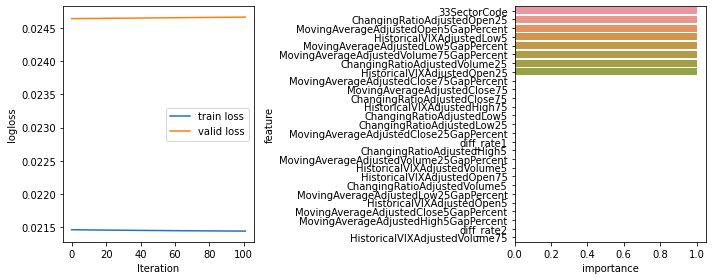

[I 2022-04-22 00:05:26,243] A new study created in memory with name: no-name-2ba4b263-bd1d-46ec-9cdb-2a63c8d6e812
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0217852	Valid's rmse: 0.0222319
[200]	Train's rmse: 0.0217624	Valid's rmse: 0.0222

feature_fraction, val_score: 0.022205:  14%|#4        | 1/7 [00:14<01:29, 14.92s/it]

Early stopping, best iteration is:
[615]	Train's rmse: 0.0216997	Valid's rmse: 0.0222048
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.197039 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

feature_fraction, val_score: 0.022204:  29%|##8       | 2/7 [00:32<01:21, 16.38s/it]

Early stopping, best iteration is:
[627]	Train's rmse: 0.0216896	Valid's rmse: 0.0222038
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

feature_fraction, val_score: 0.022204:  43%|####2     | 3/7 [00:45<01:00, 15.09s/it]

Early stopping, best iteration is:
[460]	Train's rmse: 0.0217147	Valid's rmse: 0.0222039
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training unti

feature_fraction, val_score: 0.022204:  57%|#####7    | 4/7 [01:03<00:48, 16.18s/it]

Early stopping, best iteration is:
[640]	Train's rmse: 0.0217051	Valid's rmse: 0.0222064
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

feature_fraction, val_score: 0.022204:  71%|#######1  | 5/7 [01:18<00:31, 15.71s/it]

Early stopping, best iteration is:
[592]	Train's rmse: 0.021706	Valid's rmse: 0.0222067
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

feature_fraction, val_score: 0.022201:  86%|########5 | 6/7 [01:34<00:15, 15.89s/it]

Early stopping, best iteration is:
[525]	Train's rmse: 0.0217033	Valid's rmse: 0.0222013
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

feature_fraction, val_score: 0.022201: 100%|##########| 7/7 [01:49<00:00, 15.59s/it]


Early stopping, best iteration is:
[534]	Train's rmse: 0.0217066	Valid's rmse: 0.0222031


num_leaves, val_score: 0.022201:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0215859	Valid's rmse: 0.0222297
[200]	Train's rmse: 0.0213987	Valid's rmse: 0.0222

num_leaves, val_score: 0.022201:   5%|5         | 1/20 [00:20<06:28, 20.45s/it]

Early stopping, best iteration is:
[104]	Train's rmse: 0.0215776	Valid's rmse: 0.0222273
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  10%|#         | 2/20 [00:36<05:18, 17.68s/it]

Early stopping, best iteration is:
[528]	Train's rmse: 0.0217118	Valid's rmse: 0.0222018
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  15%|#5        | 3/20 [00:51<04:39, 16.44s/it]

Early stopping, best iteration is:
[340]	Train's rmse: 0.0216718	Valid's rmse: 0.0222096
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  20%|##        | 4/20 [01:11<04:50, 18.17s/it]

Early stopping, best iteration is:
[150]	Train's rmse: 0.0215478	Valid's rmse: 0.0222275
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  25%|##5       | 5/20 [01:36<05:09, 20.64s/it]

Early stopping, best iteration is:
[199]	Train's rmse: 0.0214404	Valid's rmse: 0.0222286
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  30%|###       | 6/20 [01:57<04:47, 20.54s/it]

Early stopping, best iteration is:
[205]	Train's rmse: 0.0215601	Valid's rmse: 0.0222171
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  35%|###5      | 7/20 [02:18<04:28, 20.63s/it]

Early stopping, best iteration is:
[205]	Train's rmse: 0.0215601	Valid's rmse: 0.0222171
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  40%|####      | 8/20 [02:36<03:59, 19.98s/it]

Early stopping, best iteration is:
[155]	Train's rmse: 0.02157	Valid's rmse: 0.0222205
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rms

num_leaves, val_score: 0.022201:  45%|####5     | 9/20 [02:58<03:45, 20.52s/it]

Early stopping, best iteration is:
[275]	Train's rmse: 0.0215603	Valid's rmse: 0.0222136
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  50%|#####     | 10/20 [03:16<03:16, 19.65s/it]

Early stopping, best iteration is:
[209]	Train's rmse: 0.0216026	Valid's rmse: 0.0222122
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.192815 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  55%|#####5    | 11/20 [03:33<02:50, 18.95s/it]

Early stopping, best iteration is:
[531]	Train's rmse: 0.0217213	Valid's rmse: 0.0222026
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  60%|######    | 12/20 [03:45<02:13, 16.74s/it]

Early stopping, best iteration is:
[760]	Train's rmse: 0.0217903	Valid's rmse: 0.0222085
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  65%|######5   | 13/20 [04:00<01:54, 16.32s/it]

Early stopping, best iteration is:
[210]	Train's rmse: 0.0216677	Valid's rmse: 0.022207
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

num_leaves, val_score: 0.022201:  70%|#######   | 14/20 [04:15<01:35, 15.85s/it]

Early stopping, best iteration is:
[210]	Train's rmse: 0.021659	Valid's rmse: 0.0222089
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

num_leaves, val_score: 0.022201:  75%|#######5  | 15/20 [04:26<01:12, 14.56s/it]

Early stopping, best iteration is:
[760]	Train's rmse: 0.0217903	Valid's rmse: 0.0222085
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  80%|########  | 16/20 [04:44<01:02, 15.50s/it]

Early stopping, best iteration is:
[225]	Train's rmse: 0.0216065	Valid's rmse: 0.0222096
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

num_leaves, val_score: 0.022201:  85%|########5 | 17/20 [05:06<00:52, 17.38s/it]

Early stopping, best iteration is:
[205]	Train's rmse: 0.0215442	Valid's rmse: 0.022219
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

num_leaves, val_score: 0.022201:  90%|######### | 18/20 [05:25<00:35, 17.99s/it][I 2022-04-22 00:12:41,115] Trial 24 finished with value: 0.022223520409238348 and parameters: {'num_leaves': 150}. Best is trial 8 with value: 0.022201760611949842.


Early stopping, best iteration is:
[156]	Train's rmse: 0.0215564	Valid's rmse: 0.0222235


num_leaves, val_score: 0.022201:  90%|######### | 18/20 [05:25<00:35, 17.99s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0217371	Valid's rmse: 0.022222
[200]	Train's rmse: 0.0216785	Valid's rmse: 0.02221

num_leaves, val_score: 0.022201:  95%|#########5| 19/20 [05:39<00:16, 16.86s/it]

Early stopping, best iteration is:
[210]	Train's rmse: 0.0216731	Valid's rmse: 0.022212
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

num_leaves, val_score: 0.022201: 100%|##########| 20/20 [05:57<00:00, 17.88s/it]


Early stopping, best iteration is:
[104]	Train's rmse: 0.0216037	Valid's rmse: 0.0222301


bagging, val_score: 0.022201:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.116776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.021784	Valid's rmse: 0.0222294
[200]	Train's rmse: 0.0217585	Valid's rmse: 0.02221

bagging, val_score: 0.022201:  10%|#         | 1/10 [00:17<02:36, 17.36s/it]

Early stopping, best iteration is:
[448]	Train's rmse: 0.0217118	Valid's rmse: 0.0222009
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

bagging, val_score: 0.022198:  20%|##        | 2/10 [00:30<01:58, 14.78s/it]

Early stopping, best iteration is:
[424]	Train's rmse: 0.0217187	Valid's rmse: 0.0221976
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

bagging, val_score: 0.022198:  30%|###       | 3/10 [00:46<01:48, 15.47s/it]

Early stopping, best iteration is:
[418]	Train's rmse: 0.0217175	Valid's rmse: 0.0222072
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

bagging, val_score: 0.022198:  40%|####      | 4/10 [01:07<01:45, 17.54s/it]

Early stopping, best iteration is:
[550]	Train's rmse: 0.0216964	Valid's rmse: 0.0222067
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

bagging, val_score: 0.022198:  50%|#####     | 5/10 [01:27<01:33, 18.66s/it]

Early stopping, best iteration is:
[590]	Train's rmse: 0.0216916	Valid's rmse: 0.0222078
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

bagging, val_score: 0.022198:  60%|######    | 6/10 [01:51<01:21, 20.28s/it]

Early stopping, best iteration is:
[612]	Train's rmse: 0.0216888	Valid's rmse: 0.0222039
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

bagging, val_score: 0.022198:  70%|#######   | 7/10 [02:03<00:53, 17.75s/it]

Early stopping, best iteration is:
[368]	Train's rmse: 0.0217278	Valid's rmse: 0.0222038
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

bagging, val_score: 0.022198:  80%|########  | 8/10 [02:20<00:34, 17.45s/it]

Early stopping, best iteration is:
[387]	Train's rmse: 0.0217218	Valid's rmse: 0.0222111
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

bagging, val_score: 0.022198:  90%|######### | 9/10 [02:37<00:17, 17.25s/it]

Early stopping, best iteration is:
[488]	Train's rmse: 0.0217077	Valid's rmse: 0.0222057
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

bagging, val_score: 0.022198: 100%|##########| 10/10 [02:50<00:00, 17.08s/it]


Early stopping, best iteration is:
[312]	Train's rmse: 0.0217356	Valid's rmse: 0.0222092


feature_fraction_stage2, val_score: 0.022198:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.021783	Valid's rmse: 0.0222264
[200]	Train's rmse: 0.0217589	Valid's rmse: 0.02221

feature_fraction_stage2, val_score: 0.022198:  33%|###3      | 1/3 [00:13<00:26, 13.25s/it]

Early stopping, best iteration is:
[424]	Train's rmse: 0.0217187	Valid's rmse: 0.0221976
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

feature_fraction_stage2, val_score: 0.022198:  67%|######6   | 2/3 [00:30<00:15, 15.82s/it]

Early stopping, best iteration is:
[636]	Train's rmse: 0.0216906	Valid's rmse: 0.0221975
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

feature_fraction_stage2, val_score: 0.022198: 100%|##########| 3/3 [00:43<00:00, 14.66s/it]


Early stopping, best iteration is:
[430]	Train's rmse: 0.021718	Valid's rmse: 0.0221982


regularization_factors, val_score: 0.022198:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0217792	Valid's rmse: 0.0222291
[200]	Train's rmse: 0.021751	Valid's rmse: 0.02221

regularization_factors, val_score: 0.022198:   5%|5         | 1/20 [00:11<03:46, 11.93s/it]

[500]	Train's rmse: 0.0216888	Valid's rmse: 0.022204
Early stopping, best iteration is:
[406]	Train's rmse: 0.021707	Valid's rmse: 0.0222033
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation

regularization_factors, val_score: 0.022198:  10%|#         | 2/20 [00:22<03:19, 11.06s/it]

Early stopping, best iteration is:
[360]	Train's rmse: 0.0217194	Valid's rmse: 0.022202
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

regularization_factors, val_score: 0.022198:  15%|#5        | 3/20 [00:33<03:08, 11.08s/it]

[500]	Train's rmse: 0.0216886	Valid's rmse: 0.022204
Early stopping, best iteration is:
[406]	Train's rmse: 0.0217069	Valid's rmse: 0.0222024
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validatio

regularization_factors, val_score: 0.022198:  20%|##        | 4/20 [00:45<03:03, 11.46s/it]

[500]	Train's rmse: 0.0216887	Valid's rmse: 0.0222035
Early stopping, best iteration is:
[406]	Train's rmse: 0.0217068	Valid's rmse: 0.0222031
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validati

regularization_factors, val_score: 0.022198:  25%|##5       | 5/20 [00:56<02:49, 11.27s/it]

[500]	Train's rmse: 0.0216887	Valid's rmse: 0.0222035
Early stopping, best iteration is:
[406]	Train's rmse: 0.0217068	Valid's rmse: 0.0222031
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validati

regularization_factors, val_score: 0.022198:  30%|###       | 6/20 [01:11<02:54, 12.48s/it]

Early stopping, best iteration is:
[426]	Train's rmse: 0.0217378	Valid's rmse: 0.0222136
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022198:  35%|###5      | 7/20 [01:22<02:37, 12.11s/it]

Early stopping, best iteration is:
[360]	Train's rmse: 0.0217205	Valid's rmse: 0.0222018
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022198:  40%|####      | 8/20 [01:33<02:20, 11.74s/it]

[500]	Train's rmse: 0.0216887	Valid's rmse: 0.0222036
Early stopping, best iteration is:
[406]	Train's rmse: 0.0217073	Valid's rmse: 0.0222025
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validati

regularization_factors, val_score: 0.022198:  45%|####5     | 9/20 [01:44<02:06, 11.49s/it]

[500]	Train's rmse: 0.0216886	Valid's rmse: 0.0222036
Early stopping, best iteration is:
[406]	Train's rmse: 0.0217073	Valid's rmse: 0.0222025
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validati

regularization_factors, val_score: 0.022198:  50%|#####     | 10/20 [01:55<01:54, 11.46s/it]

Early stopping, best iteration is:
[360]	Train's rmse: 0.0217178	Valid's rmse: 0.0221994
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022198:  55%|#####5    | 11/20 [02:10<01:50, 12.30s/it]

Early stopping, best iteration is:
[368]	Train's rmse: 0.0217565	Valid's rmse: 0.0222165
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022198:  60%|######    | 12/20 [02:22<01:38, 12.29s/it]

[500]	Train's rmse: 0.0217	Valid's rmse: 0.0222011
Early stopping, best iteration is:
[406]	Train's rmse: 0.0217163	Valid's rmse: 0.0222007
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation 

regularization_factors, val_score: 0.022194:  65%|######5   | 13/20 [02:37<01:32, 13.24s/it]

Early stopping, best iteration is:
[636]	Train's rmse: 0.0216742	Valid's rmse: 0.0221944
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022194:  70%|#######   | 14/20 [02:48<01:14, 12.48s/it]

Early stopping, best iteration is:
[362]	Train's rmse: 0.0217183	Valid's rmse: 0.022202
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

regularization_factors, val_score: 0.022194:  75%|#######5  | 15/20 [03:03<01:06, 13.26s/it]

Early stopping, best iteration is:
[562]	Train's rmse: 0.0216838	Valid's rmse: 0.0221974
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022194:  80%|########  | 16/20 [03:18<00:55, 13.87s/it]

Early stopping, best iteration is:
[636]	Train's rmse: 0.0216722	Valid's rmse: 0.0221955
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022194:  85%|########5 | 17/20 [03:36<00:45, 15.06s/it]

Early stopping, best iteration is:
[588]	Train's rmse: 0.0217094	Valid's rmse: 0.0222027
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

regularization_factors, val_score: 0.022194:  90%|######### | 18/20 [03:49<00:28, 14.35s/it]

[600]	Train's rmse: 0.0216721	Valid's rmse: 0.0222027
Early stopping, best iteration is:
[500]	Train's rmse: 0.0216898	Valid's rmse: 0.022202
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validatio

regularization_factors, val_score: 0.022194:  95%|#########5| 19/20 [04:05<00:14, 14.78s/it]

Early stopping, best iteration is:
[428]	Train's rmse: 0.021759	Valid's rmse: 0.0222169
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rm

regularization_factors, val_score: 0.022194: 100%|##########| 20/20 [04:21<00:00, 13.09s/it]


Early stopping, best iteration is:
[620]	Train's rmse: 0.0216904	Valid's rmse: 0.0221977


min_data_in_leaf, val_score: 0.022194:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.021781	Valid's rmse: 0.0222278
[200]	Train's rmse: 0.0217545	Valid's rmse: 0.0

min_data_in_leaf, val_score: 0.022194:  20%|##        | 1/5 [00:16<01:06, 16.61s/it]

Early stopping, best iteration is:
[636]	Train's rmse: 0.0216742	Valid's rmse: 0.0221944
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

min_data_in_leaf, val_score: 0.022194:  40%|####      | 2/5 [00:32<00:48, 16.11s/it]

Early stopping, best iteration is:
[636]	Train's rmse: 0.0216742	Valid's rmse: 0.0221944
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse:

min_data_in_leaf, val_score: 0.022194:  60%|######    | 3/5 [00:48<00:32, 16.27s/it]

Early stopping, best iteration is:
[636]	Train's rmse: 0.0216742	Valid's rmse: 0.0221944
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

min_data_in_leaf, val_score: 0.022194:  80%|########  | 4/5 [01:04<00:15, 15.98s/it]

Early stopping, best iteration is:
[636]	Train's rmse: 0.0216742	Valid's rmse: 0.0221944
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 416522, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000230
Training until validation scores don't improve for 100 rounds
[100]	Train's r

min_data_in_leaf, val_score: 0.022194: 100%|##########| 5/5 [01:20<00:00, 16.16s/it]

Early stopping, best iteration is:
[636]	Train's rmse: 0.0216742	Valid's rmse: 0.0221944


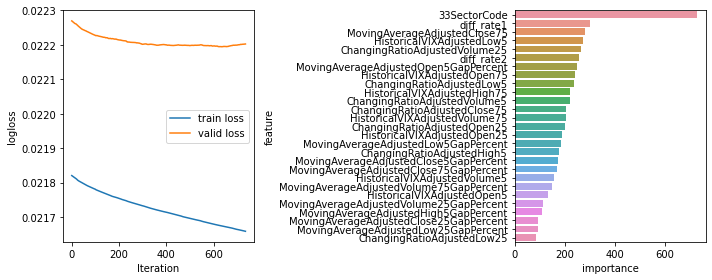

[I 2022-04-22 00:22:31,613] A new study created in memory with name: no-name-53686dfc-3c43-48ff-bdee-8fc840ad67c8
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0215202	Valid's rmse: 0.0251051
[200]	Train's rmse: 0.0214947	Valid's rmse: 0.0250

feature_fraction, val_score: 0.025038:  14%|#4        | 1/7 [00:22<02:15, 22.59s/it]

Early stopping, best iteration is:
[1030]	Train's rmse: 0.021387	Valid's rmse: 0.0250378
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.066650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's r

feature_fraction, val_score: 0.025019:  29%|##8       | 2/7 [00:46<01:57, 23.44s/it]

Early stopping, best iteration is:
[1052]	Train's rmse: 0.0213719	Valid's rmse: 0.0250194
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's 

feature_fraction, val_score: 0.025019:  43%|####2     | 3/7 [01:10<01:34, 23.53s/it]

Early stopping, best iteration is:
[1027]	Train's rmse: 0.0213792	Valid's rmse: 0.0250297
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's 

feature_fraction, val_score: 0.025019:  57%|#####7    | 4/7 [01:32<01:09, 23.21s/it]

Early stopping, best iteration is:
[1029]	Train's rmse: 0.0213837	Valid's rmse: 0.0250321
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's 

feature_fraction, val_score: 0.025018:  71%|#######1  | 5/7 [02:07<00:54, 27.19s/it]

[2000]	Train's rmse: 0.0213158	Valid's rmse: 0.0250176
Did not meet early stopping. Best iteration is:
[2000]	Train's rmse: 0.0213158	Valid's rmse: 0.0250176
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.071409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training

feature_fraction, val_score: 0.025018:  86%|########5 | 6/7 [02:31<00:26, 26.19s/it]

Early stopping, best iteration is:
[1030]	Train's rmse: 0.0213739	Valid's rmse: 0.0250205
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's 

feature_fraction, val_score: 0.025018: 100%|##########| 7/7 [02:57<00:00, 25.35s/it]


Early stopping, best iteration is:
[1147]	Train's rmse: 0.0213639	Valid's rmse: 0.0250215


num_leaves, val_score: 0.025018:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214765	Valid's rmse: 0.0250914
[200]	Train's rmse: 0.0214161	Valid's rmse: 0.0250

num_leaves, val_score: 0.024985:   5%|5         | 1/20 [00:41<13:04, 41.31s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.168737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.021497	Valid's rmse: 0.025098
[200]	Train's rmse: 0.0214533	Valid's rmse: 0.025073

num_leaves, val_score: 0.024985:  10%|#         | 2/20 [01:13<10:42, 35.70s/it]

Early stopping, best iteration is:
[1145]	Train's rmse: 0.0212252	Valid's rmse: 0.0249983
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's 

num_leaves, val_score: 0.024985:  15%|#5        | 3/20 [01:57<11:12, 39.56s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0213862	Valid's rmse: 0.0250759
[200]	Train's rmse: 0.0212465	Valid's rmse: 0.0250

num_leaves, val_score: 0.024985:  20%|##        | 4/20 [03:06<13:40, 51.26s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0213885	Valid's rmse: 0.0250763
[200]	Train's rmse: 0.0212513	Valid's rmse: 0.0250

num_leaves, val_score: 0.024985:  25%|##5       | 5/20 [04:14<14:17, 57.20s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0213748	Valid's rmse: 0.0250776
[200]	Train's rmse: 0.021225	Valid's rmse: 0.02504

num_leaves, val_score: 0.024985:  30%|###       | 6/20 [05:10<13:16, 56.86s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0215115	Valid's rmse: 0.0251053
[200]	Train's rmse: 0.0214787	Valid's rmse: 0.0250

num_leaves, val_score: 0.024985:  35%|###5      | 7/20 [05:37<10:14, 47.25s/it]

Early stopping, best iteration is:
[1190]	Train's rmse: 0.021315	Valid's rmse: 0.0250177
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training unti

num_leaves, val_score: 0.024985:  40%|####      | 8/20 [06:20<09:09, 45.77s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0213906	Valid's rmse: 0.0250764
[200]	Train's rmse: 0.0212549	Valid's rmse: 0.0250

num_leaves, val_score: 0.024985:  45%|####5     | 9/20 [07:08<08:29, 46.33s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0213992	Valid's rmse: 0.0250779
[200]	Train's rmse: 0.021272	Valid's rmse: 0.02504

num_leaves, val_score: 0.024985:  50%|#####     | 10/20 [08:12<08:38, 51.88s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214568	Valid's rmse: 0.0250849
[200]	Train's rmse: 0.0213795	Valid's rmse: 0.0250

num_leaves, val_score: 0.024975:  55%|#####5    | 11/20 [09:02<07:41, 51.32s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214563	Valid's rmse: 0.0250854
[200]	Train's rmse: 0.0213788	Valid's rmse: 0.0250

num_leaves, val_score: 0.024975:  60%|######    | 12/20 [09:52<06:47, 50.90s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214549	Valid's rmse: 0.0250847
[200]	Train's rmse: 0.0213762	Valid's rmse: 0.0250

num_leaves, val_score: 0.024975:  65%|######5   | 13/20 [10:42<05:55, 50.81s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214416	Valid's rmse: 0.0250835
[200]	Train's rmse: 0.0213511	Valid's rmse: 0.0250

num_leaves, val_score: 0.024975:  70%|#######   | 14/20 [11:34<05:05, 50.94s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214242	Valid's rmse: 0.0250813
[200]	Train's rmse: 0.021319	Valid's rmse: 0.02504

num_leaves, val_score: 0.024975:  75%|#######5  | 15/20 [12:29<04:20, 52.14s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214579	Valid's rmse: 0.0250852
[200]	Train's rmse: 0.0213819	Valid's rmse: 0.0250

num_leaves, val_score: 0.024975:  80%|########  | 16/20 [13:18<03:24, 51.19s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.021429	Valid's rmse: 0.0250822
[200]	Train's rmse: 0.0213283	Valid's rmse: 0.02505

num_leaves, val_score: 0.024975:  85%|########5 | 17/20 [13:56<02:22, 47.43s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214099	Valid's rmse: 0.0250777
[200]	Train's rmse: 0.0212924	Valid's rmse: 0.0250

num_leaves, val_score: 0.024975:  90%|######### | 18/20 [14:58<01:43, 51.74s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214599	Valid's rmse: 0.0250858
[200]	Train's rmse: 0.0213856	Valid's rmse: 0.0250

num_leaves, val_score: 0.024975:  95%|#########5| 19/20 [15:47<00:50, 50.93s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214838	Valid's rmse: 0.0250938
[200]	Train's rmse: 0.0214292	Valid's rmse: 0.0250

bagging, val_score: 0.024975:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214525	Valid's rmse: 0.0250851
[200]	Train's rmse: 0.0213726	Valid's rmse: 0.0250

bagging, val_score: 0.024975:  10%|#         | 1/10 [00:54<08:10, 54.54s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.219483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214522	Valid's rmse: 0.0250867
[200]	Train's rmse: 0.0213713	Valid's rmse: 0.0250

bagging, val_score: 0.024975:  20%|##        | 2/10 [01:40<06:34, 49.31s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064642 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214523	Valid's rmse: 0.0250834
[200]	Train's rmse: 0.0213717	Valid's rmse: 0.0250

bagging, val_score: 0.024975:  30%|###       | 3/10 [02:28<05:41, 48.82s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214542	Valid's rmse: 0.0250847
[200]	Train's rmse: 0.0213749	Valid's rmse: 0.0250

bagging, val_score: 0.024975:  40%|####      | 4/10 [03:25<05:13, 52.22s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214593	Valid's rmse: 0.0250885
[200]	Train's rmse: 0.0213854	Valid's rmse: 0.0250

bagging, val_score: 0.024975:  50%|#####     | 5/10 [04:13<04:13, 50.61s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.021448	Valid's rmse: 0.0250899
[200]	Train's rmse: 0.0213641	Valid's rmse: 0.02506

bagging, val_score: 0.024975:  60%|######    | 6/10 [04:58<03:14, 48.66s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214518	Valid's rmse: 0.0250871
[200]	Train's rmse: 0.0213701	Valid's rmse: 0.0250

bagging, val_score: 0.024975:  70%|#######   | 7/10 [05:47<02:26, 48.79s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214489	Valid's rmse: 0.0250868
[200]	Train's rmse: 0.0213637	Valid's rmse: 0.0250

bagging, val_score: 0.024975:  80%|########  | 8/10 [06:36<01:37, 48.97s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214546	Valid's rmse: 0.0250826
[200]	Train's rmse: 0.0213766	Valid's rmse: 0.0250

bagging, val_score: 0.024975:  90%|######### | 9/10 [07:20<00:47, 47.36s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214537	Valid's rmse: 0.0250879
[200]	Train's rmse: 0.0213741	Valid's rmse: 0.0250

feature_fraction_stage2, val_score: 0.024975:   0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214568	Valid's rmse: 0.0250849
[200]	Train's rmse: 0.0213795	Valid's rmse: 0.0250

feature_fraction_stage2, val_score: 0.024975:  33%|###3      | 1/3 [00:48<01:36, 48.11s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214505	Valid's rmse: 0.0250777
[200]	Train's rmse: 0.0213705	Valid's rmse: 0.0250

feature_fraction_stage2, val_score: 0.024975:  67%|######6   | 2/3 [01:40<00:50, 50.35s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214529	Valid's rmse: 0.0250809
[200]	Train's rmse: 0.0213741	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214203	Valid's rmse: 0.0250924
[200]	Train's rmse: 0.0213118	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:   5%|5         | 1/20 [00:27<08:33, 27.02s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214196	Valid's rmse: 0.0250928
[200]	Train's rmse: 0.021311	Valid's rmse: 0.02506

regularization_factors, val_score: 0.024975:  10%|#         | 2/20 [00:51<07:36, 25.37s/it]

Early stopping, best iteration is:
[671]	Train's rmse: 0.0209367	Valid's rmse: 0.0250145


[I 2022-04-22 00:53:22,352] Trial 41 finished with value: 0.025014508521017647 and parameters: {'lambda_l1': 4.709322099387306e-05, 'lambda_l2': 0.04439174216146772}. Best is trial 40 with value: 0.025009494819983137.
regularization_factors, val_score: 0.024975:  10%|#         | 2/20 [00:51<07:36, 25.37s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214519	Valid's rmse: 0.0250847
[200]	Train's rmse: 0.0213708	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  15%|#5        | 3/20 [01:38<10:04, 35.55s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation s

regularization_factors, val_score: 0.024975:  20%|##        | 4/20 [02:31<11:18, 42.42s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214192	Valid's rmse: 0.0250914
[200]	Train's rmse: 0.0213098	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  25%|##5       | 5/20 [02:59<09:14, 36.98s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214192	Valid's rmse: 0.0250931
[200]	Train's rmse: 0.0213096	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  30%|###       | 6/20 [03:24<07:40, 32.89s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214195	Valid's rmse: 0.0250935
[200]	Train's rmse: 0.0213108	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  35%|###5      | 7/20 [03:49<06:35, 30.39s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0215095	Valid's rmse: 0.025112
[LightGBM] [Warning] No further splits with positiv

regularization_factors, val_score: 0.024975:  40%|####      | 8/20 [05:23<10:08, 50.72s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214194	Valid's rmse: 0.0250925
[200]	Train's rmse: 0.0213102	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  45%|####5     | 9/20 [05:47<07:46, 42.42s/it]

Early stopping, best iteration is:
[662]	Train's rmse: 0.0209433	Valid's rmse: 0.0250187


[I 2022-04-22 00:58:18,931] Trial 48 finished with value: 0.025018692400788706 and parameters: {'lambda_l1': 4.476021550512451e-06, 'lambda_l2': 0.10682008246787082}. Best is trial 42 with value: 0.02498075956182247.
regularization_factors, val_score: 0.024975:  45%|####5     | 9/20 [05:47<07:46, 42.42s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.02149	Valid's rmse: 0.0251011
[200]	Train's rmse: 0.0214408	Valid's rmse: 0.025076

regularization_factors, val_score: 0.024975:  50%|#####     | 10/20 [06:46<07:55, 47.57s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214365	Valid's rmse: 0.0250873
[200]	Train's rmse: 0.0213415	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  55%|#####5    | 11/20 [07:24<06:41, 44.65s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214323	Valid's rmse: 0.0250868
[200]	Train's rmse: 0.0213331	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  60%|######    | 12/20 [07:53<05:18, 39.76s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214353	Valid's rmse: 0.0250861
[200]	Train's rmse: 0.0213388	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  65%|######5   | 13/20 [08:29<04:30, 38.62s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214373	Valid's rmse: 0.0250854
[200]	Train's rmse: 0.0213424	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  70%|#######   | 14/20 [09:08<03:51, 38.60s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214346	Valid's rmse: 0.0250865
[200]	Train's rmse: 0.0213371	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  75%|#######5  | 15/20 [09:50<03:18, 39.66s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214527	Valid's rmse: 0.0250852
[200]	Train's rmse: 0.0213728	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  80%|########  | 16/20 [10:40<02:51, 42.89s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214195	Valid's rmse: 0.0250926
[200]	Train's rmse: 0.0213096	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  85%|########5 | 17/20 [11:07<01:54, 38.15s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214207	Valid's rmse: 0.0250911
[200]	Train's rmse: 0.0213124	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  90%|######### | 18/20 [11:32<01:08, 34.01s/it]

Early stopping, best iteration is:
[654]	Train's rmse: 0.0209506	Valid's rmse: 0.0250182


[I 2022-04-22 01:04:03,218] Trial 57 finished with value: 0.02501815001057734 and parameters: {'lambda_l1': 0.015467029305280534, 'lambda_l2': 0.0009361115913548117}. Best is trial 55 with value: 0.024978957213522113.
regularization_factors, val_score: 0.024975:  90%|######### | 18/20 [11:32<01:08, 34.01s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214485	Valid's rmse: 0.0250839
[200]	Train's rmse: 0.0213645	Valid's rmse: 0.0250

regularization_factors, val_score: 0.024975:  95%|#########5| 19/20 [12:14<00:36, 36.59s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.068910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214195	Valid's rmse: 0.0250935
[200]	Train's rmse: 0.0213111	Valid's rmse: 0.0250

min_data_in_leaf, val_score: 0.024975:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059612 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=50 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214568	Valid's rmse: 0.0250849
[200]	Train's rmse: 0.0213795	Valid's rmse: 0.0250

min_data_in_leaf, val_score: 0.024975:  20%|##        | 1/5 [00:49<03:17, 49.46s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=100 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214568	Valid's rmse: 0.0250849
[200]	Train's rmse: 0.0213795	Valid's rmse: 0.

min_data_in_leaf, val_score: 0.024975:  40%|####      | 2/5 [01:39<02:29, 49.83s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214568	Valid's rmse: 0.0250849
[200]	Train's rmse: 0.0213795	Valid's rmse: 0.025054
[

min_data_in_leaf, val_score: 0.024975:  60%|######    | 3/5 [02:28<01:39, 49.62s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214568	Valid's rmse: 0.0250849
[200]	Train's rmse: 0.0213795	Valid's rmse: 0.0250

min_data_in_leaf, val_score: 0.024975:  80%|########  | 4/5 [03:18<00:49, 49.68s/it]

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6663
[LightGBM] [Info] Number of data points in the train set: 420699, number of used features: 27
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=10 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Start training from score 0.000288
Training until validation scores don't improve for 100 rounds
[100]	Train's rmse: 0.0214568	Valid's rmse: 0.0250849
[200]	Train's rmse: 0.0213795	Valid's rmse: 0.0250

min_data_in_leaf, val_score: 0.024975: 100%|##########| 5/5 [04:07<00:00, 49.58s/it]


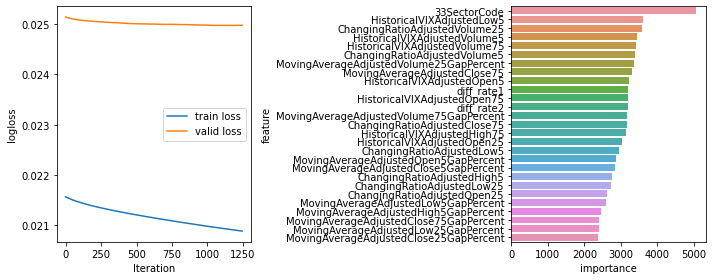

CV_SCORES: [0.12899740589835765, 0.4543590445606956, 0.4486879296122644]
CV_SCORE: 0.3440147933571059


In [20]:
# 2020-12-23よりも前のデータは証券コードが2000個すべて揃っていないため、これ以降のデータのみを使う。
# (学習用データの開始日、学習用データの終了日＝検証用データの開始日、検証用データの終了日)
fold_params = [
    ('2020-12-23', '2021-11-01', '2021-12-01'),
    ('2021-01-23', '2021-12-01', '2022-01-01'),
    ('2021-02-23', '2022-01-01', '2022-02-01'),
]
models = trainer(feature_df, feat_cols, label_col, fold_params)

# Evaluation

In [23]:
def predictor(feature_df, feat_cols, models, is_train=True):
    X = feature_df[feat_cols]
    
    # 推論
    preds = list(map(lambda model: model.predict(X, num_iteration=model.best_iteration), models))
    print(preds)
    
    # スコアは学習時のみ計算
    if is_train:
        scores = list(map(lambda pred: evaluator(feature_df, pred), preds))
        print("SCORES:", scores)

    # 推論結果をバギング
    pred = np.array(preds).mean(axis=0)

    # スコアは学習時のみ計算
    if is_train:
        score = evaluator(feature_df, pred)
        print("SCORE:", score)
    
    return pred

In [24]:
# 試験用データは学習用にも検証用にも使用していないものを使う
test_df = feature_df[('2022-02-01' <= feature_df['Date'])].copy()
pred = predictor(test_df, feat_cols, models)
pred

[array([0.00074257, 0.00074257, 0.00074257, ..., 0.00075342, 0.00071982,
       0.00072872]), array([-2.46000363e-04,  8.69382747e-05, -8.04961914e-05, ...,
        1.08611387e-03, -1.20911552e-03, -3.41828595e-04]), array([-3.26334984e-04, -6.68373770e-05, -7.98768512e-04, ...,
        2.35351554e-03, -2.64243061e-03, -4.70299300e-04])]
SCORES: [-0.15051142405326676, -0.021692750583157745, -0.043747919866109555]
SCORE: 0.002811158472073113


array([ 5.67440497e-05,  2.54222798e-04, -4.55657360e-05, ...,
        1.39768333e-03, -1.04390711e-03, -2.78033099e-05])

# Submit

In [32]:
# 時系列APIのロード
import jpx_tokyo_market_prediction
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

Exception: You can only call `make_env()` once.

In [28]:
# supplemental filesを履歴データの初期状態としてセットアップ
past_df = train_df.copy()

In [33]:
# 日次で推論・登録
for i, (prices, options, financials, trades, secondary_prices, sample_prediction) in enumerate(iter_test):
    current_date = prices["Date"].iloc[0]
    print(f"count {i}, {current_date}")

    if i == 0:
        # リークを防止するため、時系列APIから受け取ったデータより未来のデータを削除
        past_df = past_df[past_df["Date"] < current_date]

    # リソース確保のため古い履歴を削除
    threshold = (pd.Timestamp(current_date) - pd.offsets.BDay(80)).strftime("%Y-%m-%d")
    past_df = past_df[past_df["Date"] >= threshold]
    
    # 時系列APIから受け取ったデータを履歴データに統合
    base_df = collector(prices, options, financials, trades, secondary_prices, stock_list)
    past_df = pd.concat([past_df, base_df]).reset_index(drop=True)

    # 特徴量エンジニアリング
    feature_df, feat_cols, label_col = preprocessor(past_df, False)

    # 予測対象レコードだけを抽出
    feature_df = feature_df[feature_df['Date'] == current_date]

    # 推論
    feature_df["pred"] = predictor(feature_df, feat_cols, models, False)

    # 推論結果からRANKを導出し、提出データに反映
    feature_df = add_rank(feature_df)
    write_df(feature_df, f"result_{i}")
    feature_map = feature_df.set_index('SecuritiesCode')['Rank'].to_dict()
    sample_prediction['Rank'] = sample_prediction['SecuritiesCode'].map(feature_map)

    # 結果を登録
    env.predict(sample_prediction)

Exception: You can only iterate over `iter_test()` once.